# **Getting the features**

In [3]:
%env CUDA_VISIBLE_DEVICES=0
!rm -rf .cache *.bz2 utils.py*
!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/SPECTRAL_STACK50_NFILT40_c11783_features.csv.bz2
#!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/SPECTRAL_STACKFREE_NFILT40_c74e01_features.csv.bz2 ||  echo "SPECTRAL_STACKFREE_NFILT40_c74e01_features.csv.bz2 not found"
!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/utils.py || echo "utils.py not found"
  
!bunzip2 -f *.bz2


env: CUDA_VISIBLE_DEVICES=0


In [4]:
from google.colab import files

from utils import *

from sklearn.utils import check_X_y
from sklearn.utils.multiclass import unique_labels

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline

Using TensorFlow backend.


# **Loading/preparing features and calls**

In [5]:
# some common values
n_filters = 40

n_dimensions = 20

species = ['BM-Kenya', 'BM-Uganda', 'PN', 'TT', 'CB', 'CL']

to_remove = ['x', 'A', 'A*', 'Nscrm', 'BO', 'BS', 'Bw', 'C', 'K+/W+']

call2species = {'1':'PN', '2':'PN', '3':'PN', '4':'PN', 
                'A':'BM-Kenya', 'A*':'BM-Kenya', 'KA':'BM-Kenya', 'KATR':'BM-Kenya', 'Nscrm':'BM-Kenya', 'PY':'BM-Kenya', 'BO':'BM-Kenya',
                'h':'BM-Uganda', 'p':'BM-Uganda',
                'A_titi':'TT', 'B':'TT', 'BS':'TT', 'Bw':'TT',  'C':'TT', 'H':'TT', 'x':'TT',  
                'H':'CB', 'K':'CB', 'K+':'CB', 'W':'CB', 'W+':'CB', 'K+/W+':'CB',                 
                'r':'CL', 's':'CL'}


# reading features and labels, in the csv file the first column are the calls/labels 
# the rest are features
features_, labels_ = read_csv('SPECTRAL_STACK50_NFILT40_c11783_features.csv')            
labels = pd.DataFrame(labels_).values.reshape(-1)
features = pd.DataFrame(features_).values
features = StandardScaler().fit_transform(features)

# only to have the names similar to other people's code
x = features.astype(np.float32)
y = LabelEncoder().fit(labels).transform(labels)

# shuffling features and labels to have mixed species
indices = np.arange(len(x))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
shuffled_labels = labels[indices]

# if you do train/test splits
train_x, val_x, train_y, val_y = train_test_split(x, y, train_size=0.8, stratify=y)


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# **Computing PCA and plotting the features**

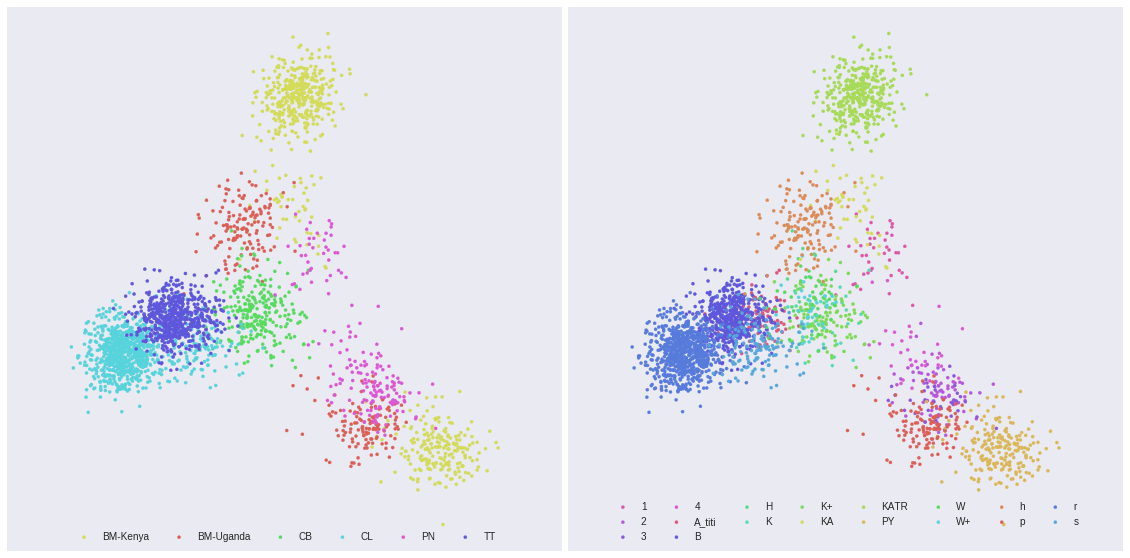

In [6]:
class my_LinearDiscriminantAnalysis(LinearDiscriminantAnalysis):
    '''Modified LDA to get a variable number of output dimensions'''

    def fit(self, X, y):
        """Fit LinearDiscriminantAnalysis model according to the given
        training data and parameters.
        .. versionchanged:: 0.19
            *store_covariance* has been moved to main constructor.
        .. versionchanged:: 0.19
            *tol* has been moved to main constructor.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        y : array, shape (n_samples,)
            Target values.
        """
        X, y = check_X_y(X, y, ensure_min_samples=2, estimator=self)
        self.classes_ = unique_labels(y)

        if self.priors is None:  # estimate priors from sample
            _, y_t = np.unique(y, return_inverse=True)  # non-negative ints
            self.priors_ = np.bincount(y_t) / float(len(y))
        else:
            self.priors_ = np.asarray(self.priors)

        if (self.priors_ < 0).any():
            raise ValueError("priors must be non-negative")
        if self.priors_.sum() != 1:
            warnings.warn("The priors do not sum to 1. Renormalizing", UserWarning)
            self.priors_ = self.priors_ / self.priors_.sum()

        # Get the maximum number of components
        if self.n_components is None:
            self._max_components = len(self.classes_) - 1
        else:
            self._max_components = max(len(self.classes_) - 1,
                                    self.n_components)

        if self.solver == 'svd':
            if self.shrinkage is not None:
                raise NotImplementedError('shrinkage not supported')
            self._solve_svd(X, y)
        elif self.solver == 'lsqr':
            self._solve_lsqr(X, y, shrinkage=self.shrinkage)
        elif self.solver == 'eigen':
            self._solve_eigen(X, y, shrinkage=self.shrinkage)
        else:
            raise ValueError("unknown solver {} (valid solvers are 'svd', "
                            "'lsqr', and 'eigen').".format(self.solver))
        if self.classes_.size == 2:  # treat binary case as a special case
            self.coef_ = np.array(self.coef_[1, :] - self.coef_[0, :], ndmin=2)
            self.intercept_ = np.array(self.intercept_[1] - self.intercept_[0],
                                    ndmin=1)
        return self


lda = my_LinearDiscriminantAnalysis(n_components=n_dimensions)
lda.fit(features, labels)
lda_ = lda.transform(features)

lda_grouped = to_pandas(lda_, labels)
plot_labels(lda_grouped, 'LDA Dimension reduction')


# **ABX plots**

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


LinAlgError: ignored

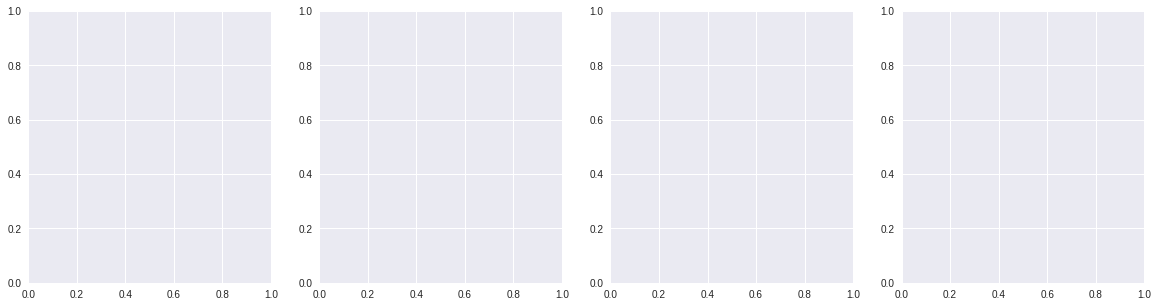

In [8]:
#plot_abx(lda_, labels)

# **Save & download new features**

In [0]:
lda_features = np.append(labels.reshape(-1,1), lda_, axis=1)
fname = "LDA_dimension_reduction_features_{:02d}D.csv".format(n_dimensions)
pd.DataFrame(lda_features).to_csv(fname)
files.download(fname)